In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Notebook Setup

In this notebook, I will define the five most popular commuter trips for Lyft Bay Wheels and come up with some suggestions to explore in order to increase profitability

### Part 1

In my investigation into the dataset, the first question I want to answer is what are the five most popular commuter trips? This will take me defining what a commuter trip is, then looking in the data for the answer once I pare down the data. To start, I will go through the process of defining a "commuter trip".

When I am starting the process, the first step is to use some common knowledge to set intial parameters. In the population that we are looking at (Bay Area employees) a general idea for working hours is 9-5, Monday through Friday. We can start to reduce our dataset to observations that are on a weekday.

#### This is the SQL for the Weekday_Trips View created
```
'SELECT * 
    FROM (SELECT *,
      CASE EXTRACT(DAYOFWEEK
      FROM
        start_date)
        WHEN 1 THEN "Sunday"
        WHEN 2 THEN "Monday"
        WHEN 3 THEN "Tuesday"
        WHEN 4 THEN "Wednesday"
        WHEN 5 THEN "Thursday"
        WHEN 6 THEN "Friday"
        WHEN 7 THEN "Saturday"
    END
      AS Day_of_Week,
      FROM
    `bigquery-public-data.san_francisco.bikeshare_trips`)
WHERE Day_of_Week <> "Saturday" AND DAY_of_Week <> "Sunday"'
```

Now that we have our data reduced to only weekday observations, we can look at the amount of rides that were taken during each hour of the day to get an idea of when popular commute hours might be.

In [77]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT\
  COUNT(*) AS Number_of_Trips,\
  Start_Hour\
FROM (SELECT *,\
EXTRACT(HOUR from start_date) as Start_Hour,\
CAST(ROUND(duration_sec / 60.0) AS INT64) AS duration_minutes\
FROM bike_trip_data.Weekday_Trips)\
GROUP BY\
  Start_Hour\
ORDER BY\
  Number_of_Trips ASC' > WeekdayHours.csv

Waiting on bqjob_r6f3b342fc52e8c7a_00000174d6e1f478_1 ... (1s) Current status: DONE   


In [78]:
WeekdayHours = pd.read_csv('WeekdayHours.csv')
WeekdayHours

,Number_of_Trips,Start_Hour
0,420,2
1,427,3
2,797,1
3,1273,4
4,1696,0
5,4797,23
6,4799,5
7,8343,22
8,12828,21
9,19492,20


Text(0.5, 1.0, 'Number of Rides for each Hour in Weekday')

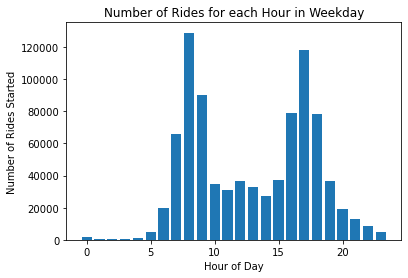

In [79]:
plt.bar(WeekdayHours["Start_Hour"], WeekdayHours["Number_of_Trips"])
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides Started')
plt.title('Number of Rides for each Hour in Weekday')

When we look at the amount of trips per hour, we can see that there are some hours that have a much greater ridership. Thinking about our business, this would appear to indicate that these hours would have more commuters in general (especially since the most popular trip start hours are centered around what we consider traditional work hours), letting us narrow down our trips further (7-9 am, 4-6 pm).

#### This is SQL for the view WeekdayCommuteHours
```
SELECT
  *
FROM (
  SELECT
    *,
    EXTRACT(HOUR
    FROM
      start_date) AS Start_Hour,
    CAST(ROUND(duration_sec / 60.0) AS INT64) AS duration_minutes
  FROM
    bike_trip_data.Weekday_Trips)
WHERE
  (Start_Hour > 6
    AND Start_Hour < 10)
  OR ((Start_Hour > 3
      AND Start_Hour < 7))
```

Next, we can realize that a commute would likely involve going from one station to another (returning to the original station would be more likely to be exercise or purely for enjoyment). With this, we can narrow down our dataset once more. Once we do that, we can think about another factor: the length of the trip. We can go ahead and look at some of the times that our trips took.

#### SQL for View WeekdayCrossStationTrips
```
SELECT
  *
FROM
    bike_trip_data.WeekdayCommuteHours
WHERE
  start_station_name <> end_station_name
```

In [68]:
! bq query --use_legacy_sql=FALSE --format=csv \
'SELECT\
  COUNT(*) AS Number_of_Trips,\
  CASE\
    WHEN duration_minutes < 5 THEN "Less than 5"\
    WHEN duration_minutes >= 5\
  AND duration_minutes < 15 THEN "Between 5 and 15"\
    WHEN duration_minutes >=15 AND duration_minutes < 30 THEN "Between 15 and 30"\
    WHEN duration_minutes >= 30\
  AND duration_minutes < 45 THEN "Between 30 and 45"\
    WHEN duration_minutes >=45 AND duration_minutes < 60 THEN "Between 45 and 60"\
    WHEN duration_minutes >= 60 THEN "More than 1 hour"\
END\
  AS Trip_Duration\
FROM bike_trip_data.WeekdayCrossStationTrips\
GROUP BY\
  Trip_Duration' > CommuteTripTime.csv

Waiting on bqjob_r4289d0e60f29a1fb_00000174d6df79fb_1 ... (1s) Current status: DONE   


In [69]:
triptime = pd.read_csv('CommuteTripTime.csv')

In [70]:
triptime

,Number_of_Trips,Trip_Duration
0,41929,Less than 5
1,235235,Between 5 and 15
2,28574,Between 15 and 30
3,795,Between 30 and 45
4,1382,More than 1 hour
5,285,Between 45 and 60


Text(0.5, 1.0, 'Number of Trips for given Duration')

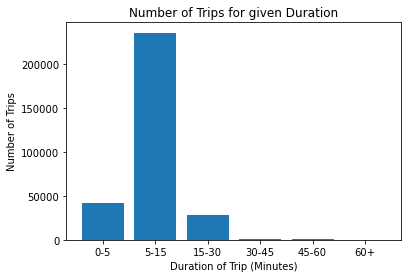

In [71]:
plt.bar(["0-5", "5-15", "15-30", "30-45", "45-60", "60+"], triptime["Number_of_Trips"])
plt.xlabel("Duration of Trip (Minutes)")
plt.ylabel("Number of Trips")
plt.title("Number of Trips for given Duration")

When we look at our results, we can see that the majority of our trips are less than 30 minutes. Since we are looking for the most popular commute trips, we can go ahead and limit our view to trips that took less than 30 minutes (since even if the other trips are commuters, it isn't the core ridership). We then need to investigate the trips that took less than 5 minutes. If we see a lot of 1 minute trips, we should be able to disregard those since they are likely input errors or mechanical failures.

In [72]:
! bq query --use_legacy_sql=FALSE --format=csv \
'SELECT\
  COUNT(*) AS Number_of_Trips,\
  CASE\
    WHEN duration_sec >= 0\
  AND duration_sec < 60 THEN "Between 0 and 1"\
    WHEN duration_sec >=60 AND duration_sec < 120 THEN "Between 1 and 2"\
    WHEN duration_sec >= 120\
  AND duration_sec < 180 THEN "Between 2 and 3"\
    WHEN duration_sec >=180 AND duration_sec < 240 THEN "Between 3 and 4"\
    WHEN duration_sec >= 240 AND duration_sec < 300 THEN "Between 4 and 5"\
    ELSE "5 or More Minutes"\
END\
  AS Trip_Duration\
FROM bike_trip_data.WeekdayCrossStationTrips\
GROUP BY\
  Trip_Duration' > CommuteTripTime.csv

Waiting on bqjob_rf2812a39e52e5b8_00000174d6e01d93_1 ... (1s) Current status: DONE   


In [73]:
fivemintrip = pd.read_csv("CommuteTripTime.csv")

In [74]:
fivemintrip

,Number_of_Trips,Trip_Duration
0,20429,Between 3 and 4
1,25925,Between 4 and 5
2,252935,5 or More Minutes
3,7197,Between 2 and 3
4,1714,Between 1 and 2


When we look at the breakdown for the trips within 5 minutes, we can see that the majority are between 3 and 5 minutes. If we look at our station map, this is feasible since we can commute between many stations in around 3 minutes (some stations are less than a block to a couple of blocks apart in the city). For those less than 3 minutes, we can go ahead and exclude them. This lets use reduce down our trips once more.

#### SQL for View IncludeDuration
```
SELECT
  *
FROM
  bike_trip_data.WeekdayCrossStationTrips
WHERE
  duration_sec >= 180
  AND duration_minutes < 30
```

Finally, one more thing that we want to look at is the amount of subscriber trips versus customer trips. We would imagine that if these trips really are commuter trips, the individuals will likely be subscribers since the way membership works if you ride a bike more than once a week (there and back) it will be a better deal to join as a member than to pay for each ride individually.

In [80]:
! bq query --use_legacy_sql=FALSE --format=csv \
'SELECT COUNT(*) AS Number_of_Trips, \
    subscriber_type \
FROM bike_trip_data.IncludeDuration \
GROUP BY subscriber_type' > Subscriber.csv

Waiting on bqjob_r1ed45c45b3acf79c_00000174d6e27f7c_1 ... (1s) Current status: DONE   


In [81]:
subnum = pd.read_csv("Subscriber.csv")
subnum

,Number_of_Trips,subscriber_type
0,288259,Subscriber
1,8568,Customer


Text(0.5, 1.0, 'Number of Trips for each Subscriber Type')

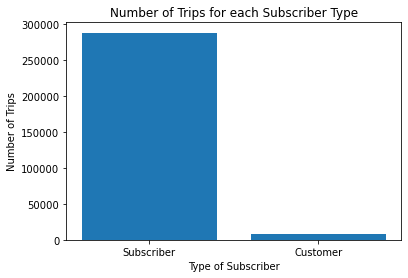

In [82]:
plt.bar(subnum["subscriber_type"], subnum["Number_of_Trips"])
plt.xlabel("Type of Subscriber")
plt.ylabel("Number of Trips")
plt.title("Number of Trips for each Subscriber Type")

We see that as we suspect, most of the trips taken during what we've determined to be commute times are from subscribers. We can then reduce our data to only subscriber trips.

#### SQL for view CommuteTrips
```
SELECT
  *
FROM
  bike_trip_data.IncludeDuration
WHERE
  subscriber_type = "Subscriber"
```

Now that we have our reduced database of "commuter trips", we need to determine the five most popular ones. To do this, we must consider how we want to define a trip. The way that I am going to determine the popularity of a trip is to find the total number of rides that go between the stations. This means that we will combine rides that start at Station A and end at Station B with the rides that start at Station B and end at Station A (we can't just look at one direction since there might be some factors around station at the other end of a commute that causes more or less ridership). To get this, we can first create a data table that gives the number of trips for a given starting and ending station.

In [83]:
! bq query --use_legacy_sql=FALSE --format=csv \
'SELECT\
  start_station_name,\
  end_station_name,\
  COUNT(*) AS Number_of_Trips\
FROM\
  bike_trip_data.CommuteTrips\
GROUP BY\
  start_station_name,\
  end_station_name' > TripNumbers.csv

Waiting on bqjob_r58c7673092adfd1e_00000174d6f69d2d_1 ... (1s) Current status: DONE   


In [84]:
tripnum = pd.read_csv("TripNumbers.csv")
tripnum.head()

,start_station_name,end_station_name,Number_of_Trips
0,Redwood City Caltrain Station,Mezes,6
1,MLK Library,Japantown,10
2,Ryland Park,Japantown,34
3,St James Park,Japantown,6
4,San Pedro Square,Japantown,1


We may think that we are now done (just take the top five values from this table and call it a day). However, we need to realize that for our defintion, we still need to add up the inverse of trips as well (A to B as well as B to A). To do this, we can create a mirror of the table and use a join to add these together.

#### SQL for view TotalTripsEachRoute
```
SELECT
  One.start_station_name as Station_1, One.end_station_name as Station_2, 
  (One.Number_of_Trips + Two.Number_of_Trips) as Num_Trips
FROM
    bike_trip_data.StartTripNumber AS One
INNER JOIN bike_trip_data.StartTripNumber2 AS Two ON 
        (One.start_station_name = Two.ending AND One.end_station_name = Two.start)
```

In this SQL, the two versions of the table from above are StartTripNumber and StartTripNumber2 (The mirror has the column names changed to make it easier for me to work with both).

Now, we can look at our final table, with which we are two steps away from determining the most popular commuting trips.

In [91]:
! bq query --use_legacy_sql=FALSE --format=csv \
'SELECT * \
FROM bike_trip_data.FinalCommuteTable' > commute.csv

Waiting on bqjob_r5730569f04005e3c_00000174d752c18d_1 ... (2s) Current status: DONE   


In [92]:
commutetable = pd.read_csv("commute.csv")
commutetable.head()

,Station_1,Station_2,Num_Trips
0,Redwood City Caltrain Station,Mezes,95
1,MLK Library,Japantown,51
2,Ryland Park,Japantown,38
3,St James Park,Japantown,15
4,San Pedro Square,Japantown,25


The one remaining issue in this table is the fact that for each route that had trips going both ways we will have two values representing it. We then can take the top 10 trips (since each of the top five is duplicated) and take every second row to get the five most popular commuting trips.

In [93]:
! bq query --use_legacy_sql=FALSE --format=csv \
'SELECT\
  *\
FROM\
  bike_trip_data.FinalCommuteTable\
ORDER BY Num_Trips DESC\
' > Duplicate.csv

Waiting on bqjob_r5b499f7b5dcee7b8_00000174d75c57cf_1 ... (1s) Current status: DONE   


In [94]:
duptable = pd.read_csv("Duplicate.csv")
duptable.head()

,Station_1,Station_2,Num_Trips
0,Harry Bridges Plaza (Ferry Building),2nd at Townsend,5708
1,2nd at Townsend,Harry Bridges Plaza (Ferry Building),5708
2,Temporary Transbay Terminal (Howard at Beale),San Francisco Caltrain (Townsend at 4th),5071
3,San Francisco Caltrain (Townsend at 4th),Temporary Transbay Terminal (Howard at Beale),5071
4,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),4934


In [98]:
duptable.iloc[::2].reset_index(drop=True).head(5)

,Station_1,Station_2,Num_Trips
0,Harry Bridges Plaza (Ferry Building),2nd at Townsend,5708
1,Temporary Transbay Terminal (Howard at Beale),San Francisco Caltrain (Townsend at 4th),5071
2,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),4934
3,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,4816
4,Steuart at Market,2nd at Townsend,4749


At the end of our procedure, we find that the five most popular commuter trips are between
```
1. Harry Bridges Plaza (The Ferry Building) and 2nd at Townsend with 5708 trips

2. Temporary Transbay Terminal (Howard at Beale) and San Francisco Caltrain (Townsend at 4th) with 5071 trips
    
3. San Francisco Caltrain(Townsend at 4th) and Harry Bridges Plaza (The Ferry Building) with 4934 trips

4. San Francisco Caltrain 2 (330 Townsend) and Townsend at 7th with 4816 trips

5. Steuart at Market and 2nd at Townsend with 4749 trips
```

### Part 2

Now that we have figured out the 5 most popular commuter trips, we can then turn our attention to possible reccomendations to improve revenue. First we can look to see if we can find any differences between subscribers (our presumably regular customers) and our customers (one-off riders). 

In [2]:
! bq query --use_legacy_sql=FALSE --max_rows=1000000 --format=csv \
'SELECT duration_sec, subscriber_type\
FROM `bigquery-public-data.san_francisco.bikeshare_trips`' > sublength.csv

Waiting on bqjob_r5ac805f4ab1c877_00000174dd61332c_1 ... (6s) Current status: DONE   


In [8]:
dat = pd.read_csv("sublength.csv")
dat.head()

,duration_sec,subscriber_type
0,2618,Customer
1,5957,Customer
2,5913,Customer
3,6079,Customer
4,5780,Customer


In [37]:
subs = dat[dat["subscriber_type"] == "Subscriber"]
custs = dat[dat["subscriber_type"] == "Customer"]
vals = [subs["duration_sec"], custs["duration_sec"]]
print("There are " + str(len(subs)) + " Subscriber trips and " + str(len(custs)) + " Customer Trips in our data")

There are 846839 Subscriber trips and 136809 Customer Trips in our data


Text(0.5, 1.0, 'Density plot for Ride Duration give Subscriber Type')

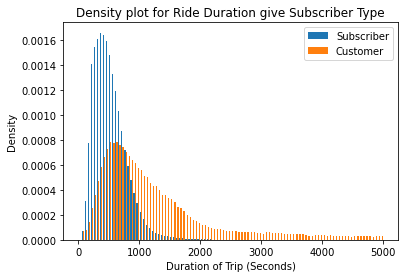

In [33]:
plt.hist(vals, bins =100, range = (0,5000), density=True, label=["Subscriber", "Customer"])
plt.legend()
plt.xlabel("Duration of Trip (Seconds)")
plt.ylabel("Density")
plt.title("Density plot for Ride Duration give Subscriber Type")

Now that we see that there appears to be a significant difference in ride length between customers and subscribers, we can look into our customer data a little more to see if there are any possible changes to increase ridership.

In [20]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT\
  COUNT(*) AS Number_of_Trips,\
  Start_Hour,\
FROM (SELECT *,\
EXTRACT(HOUR from start_date) as Start_Hour,\
CAST(ROUND(duration_sec / 60.0) AS INT64) AS duration_minutes\
FROM bigquery-public-data.san_francisco.bikeshare_trips)\
WHERE\
    subscriber_type = "Customer"\
GROUP BY\
  Start_Hour\
ORDER BY\
  Start_Hour ASC' > CustomerHours.csv

Waiting on bqjob_r464bf8f38b9df272_00000174e03a72f5_1 ... (0s) Current status: DONE   


In [22]:
chours = pd.read_csv("CustomerHours.csv")
chours.head()

,Number_of_Trips,Start_Hour
0,848,0
1,639,1
2,413,2
3,208,3
4,160,4


Text(0.5, 1.0, 'Number of Rides for each Hour Given Rider is a Customer')

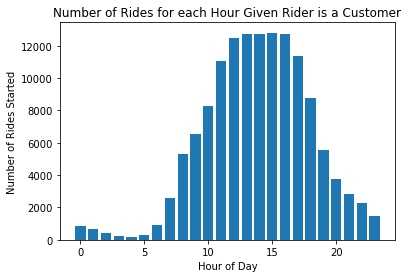

In [23]:
plt.bar(chours["Start_Hour"], chours["Number_of_Trips"])
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides Started')
plt.title('Number of Rides for each Hour Given Rider is a Customer')

In [39]:
! bq query --use_legacy_sql=FALSE --format=csv \
'SELECT\
  COUNT(*) AS Number_of_Trips,\
  Day_of_Week,\
  MAX(dow) AS dow,\
  sum(duration_minutes) / COUNT (*) AS Average_Trip_Length_Minutes\
FROM (\
  SELECT\
    *,\
    CASE EXTRACT(DAYOFWEEK\
    FROM\
      start_date)\
      WHEN 1 THEN "Sunday"\
      WHEN 2 THEN "Monday"\
      WHEN 3 THEN "Tuesday"\
      WHEN 4 THEN "Wednesday"\
      WHEN 5 THEN "Thursday"\
      WHEN 6 THEN "Friday"\
      WHEN 7 THEN "Saturday"\
  END\
    AS Day_of_Week,\
    EXTRACT(DAYOFWEEK\
    FROM\
      start_date) AS dow,\
    EXTRACT(HOUR\
    FROM\
      start_date) AS Start_Hour,\
    CAST(ROUND(duration_sec / 60.0) AS INT64) AS duration_minutes\
  FROM\
    bigquery-public-data.san_francisco.bikeshare_trips)\
WHERE\
  subscriber_type = "Customer"\
GROUP BY\
  Day_of_Week\
ORDER BY\
  dow ASC' > CustomerDays.csv

Waiting on bqjob_r44ed27d1598d26fd_00000174e0486b72_1 ... (0s) Current status: DONE   


In [40]:
cdays = pd.read_csv("CustomerDays.csv")
cdays

,Number_of_Trips,Day_of_Week,dow,Average_Trip_Length_Minutes
0,25908,Sunday,1,68.511772
1,15142,Monday,2,54.198983
2,14737,Tuesday,3,52.004343
3,15237,Wednesday,4,51.733871
4,16612,Thursday,5,53.892186
5,19929,Friday,6,60.493753
6,29244,Saturday,7,76.228184


Text(0.5, 1.0, 'Number of Rides for each Day Of Week Given Rider is a Customer')

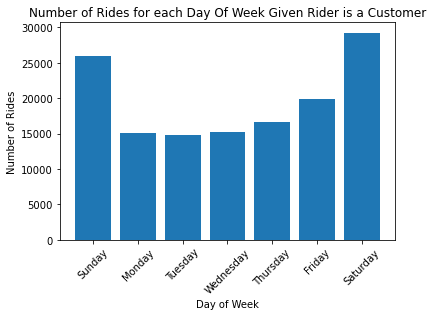

In [36]:
plt.bar(cdays["Day_of_Week"], cdays["Number_of_Trips"])
plt.xticks(rotation=45)
plt.xlabel('Day of Week')
plt.ylabel('Number of Rides')
plt.title('Number of Rides for each Day Of Week Given Rider is a Customer')

Text(0.5, 1.0, 'Average Ride Length for each Day Of Week Given Rider is a Customer')

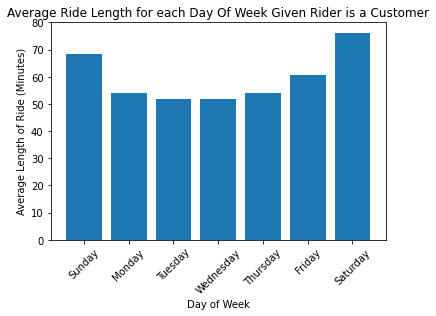

In [42]:
plt.bar(cdays["Day_of_Week"], cdays["Average_Trip_Length_Minutes"])
plt.xticks(rotation=45)
plt.xlabel('Day of Week')
plt.ylabel('Average Length of Ride (Minutes)')
plt.title('Average Ride Length for each Day Of Week Given Rider is a Customer')

We can now see that unlike the subscriber distribution (concentrated around dual peaks of 8 am and 5 pm) our customers seem to prefer rides during the middle of the day, roughly from 10 or 11 am until 6pm. Also, unlike the trends for rides per day we saw in our dataset as a whole there are more customers that ride on the weekend as opposed to the weekday. Finally, we can also see that the trips taken by customers appear to be longer (the average of each day is 50 minutes) as compared to length of subscribers and their commute times. Since midday both during the week and on the weekend doesn't impact our core clientele (subscribers who tend to commute at certain hours), we can look at offers in this space to help bring in new riders and encourage pickup of our service.

#### First Reccomendations
I would reccomend offering day passes on the weekends where for a set charge (10 or 20 dollars) a rider could rent a bike between 10am and 4pm. This could help encourage ridership by making longer trips and day trips more convenient, allowing us to be more competitive for recreational transportation. Another offer that I would like to propose would be a midday ride voucher. Akin to the free BART pass in San Francisco, the midday ride voucher would allow for the first 30 minutes and unlocking of the bike to be free (as compared to the current values where it costs 2 dollars to unlock and 2 dollars for the first 30 minutes) as long as the bike is checked our between 10 am and 3 pm. This sort of free incentive can generate interest in our service, and help introduce potential customers and subscribers to our business.

A different avenue of exploration would be to look at the traffic (in terms of total number of trips) at each station in our dataset (accounting for installation times).

In [44]:
! bq query --use_legacy_sql=FALSE --format=csv \
'SELECT\
  table1.Trip_Total,\
  table1.Station,\
  table2.landmark,\
  table2.installation_date\
FROM (\
  SELECT\
    table1.Num_Trips + table2.Number_of_Trips AS Trip_Total,\
    table1.Station1 AS Station\
  FROM (\
    SELECT\
      COUNT(*) AS Num_Trips,\
      start_station_name AS Station1\
    FROM\
      `bigquery-public-data.san_francisco.bikeshare_trips`\
    GROUP BY\
      start_station_name\
    ORDER BY\
      Num_Trips ASC )AS table1\
  LEFT JOIN (\
    SELECT\
      COUNT(*) AS Number_of_Trips,\
      end_station_name AS Station2\
    FROM\
      `bigquery-public-data.san_francisco.bikeshare_trips`\
    GROUP BY\
      end_station_name\
    ORDER BY\
      Number_of_Trips ASC) AS table2\
  ON\
    table1.Station1 = table2.Station2\
  ORDER BY\
    Trip_Total) AS table1\
INNER JOIN (\
  SELECT\
    *\
  FROM\
    `bigquery-public-data.san_francisco.bikeshare_stations`) AS table2\
ON\
  table1.Station = table2.name\
ORDER BY\
  installation_date ASC, Trip_Total,\
  installation_date' > StationTrips.csv

Waiting on bqjob_r5c511215da8f67e7_00000174e0547c14_1 ... (0s) Current status: DONE   


In [45]:
stattrip = pd.read_csv("StationTrips.csv")
stattrip.head()

,Trip_Total,Station,landmark,installation_date
0,3951,Arena Green / SAP Center,San Jose,2013-08-05
1,3975,Adobe on Almaden,San Jose,2013-08-05
2,4539,San Salvador at 1st,San Jose,2013-08-05
3,4570,San Jose Civic Center,San Jose,2013-08-05
4,5961,Japantown,San Jose,2013-08-05


Text(0.5, 0, 'Creation of Station')

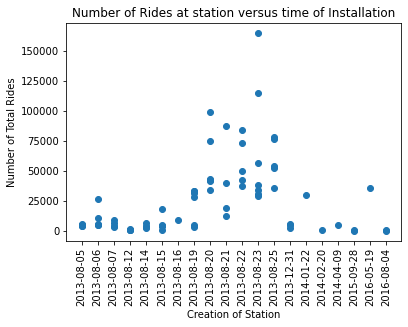

In [46]:
plt.scatter(stattrip["installation_date"], stattrip["Trip_Total"])
plt.xticks(rotation=90)
plt.title("Number of Rides at station versus time of Installation")
plt.ylabel("Number of Total Rides")
plt.xlabel("Creation of Station")

When we look at the previous plot, we can see that there are clearly some stations that were around for our entire lifetime of sampling yet had very few rides as compared to other stations. We can take a closer look at some of those stations to see if there are any avenues for improvement/adjustment.

In [49]:
# Select Stations built before 2014 and with less than 10,000 trips
! bq query --use_legacy_sql=FALSE --format=csv \
'SELECT\
  table1.Trip_Total,\
  table1.Station,\
  table2.landmark,\
  table2.installation_date\
FROM (\
  SELECT\
    table1.Num_Trips + table2.Number_of_Trips AS Trip_Total,\
    table1.Station1 AS Station\
  FROM (\
    SELECT\
      COUNT(*) AS Num_Trips,\
      start_station_name AS Station1\
    FROM\
      `bigquery-public-data.san_francisco.bikeshare_trips`\
    GROUP BY\
      start_station_name\
    ORDER BY\
      Num_Trips ASC )AS table1\
  LEFT JOIN (\
    SELECT\
      COUNT(*) AS Number_of_Trips,\
      end_station_name AS Station2\
    FROM\
      `bigquery-public-data.san_francisco.bikeshare_trips`\
    GROUP BY\
      end_station_name\
    ORDER BY\
      Number_of_Trips ASC) AS table2\
  ON\
    table1.Station1 = table2.Station2\
  ORDER BY\
    Trip_Total) AS table1\
INNER JOIN (\
  SELECT\
    *\
  FROM\
    `bigquery-public-data.san_francisco.bikeshare_stations`) AS table2\
ON\
  table1.Station = table2.name\
WHERE \
  Trip_Total < 10000\
  AND\
  installation_date < "2014-01-01"\
ORDER BY\
  installation_date ASC, Trip_Total,\
  installation_date' > StationTrips.csv

Waiting on bqjob_r331835f238e91560_00000174e0569c9c_1 ... (1s) Current status: DONE   


In [50]:
stattripmod = pd.read_csv("StationTrips.csv")
stattripmod.head()

,Trip_Total,Station,landmark,installation_date
0,3951,Arena Green / SAP Center,San Jose,2013-08-05
1,3975,Adobe on Almaden,San Jose,2013-08-05
2,4539,San Salvador at 1st,San Jose,2013-08-05
3,4570,San Jose Civic Center,San Jose,2013-08-05
4,5961,Japantown,San Jose,2013-08-05


We can see that these stations are very sparse as compared to some of the other stations in our dataset (the lowest stations have around 3-4 trips started or ended there per day). We might want to investigate to see if there are any actions that we should take.

We can also look at a breakdown of trips in regions, not just stations. We can see that there are five different regions in the dataset (San Jose, Palo Alto, Mountain View, Redwood City, San Francisco) and we can look at the total number of trips versus the amount of stations.

In [90]:
! bq query --use_legacy_sql=FALSE --format=csv \
'SELECT\
  COUNT(*) AS Number_of_Stations,\
  SUM(table1.Trip_Total) AS Total_Trips,\
  table2.landmark,\
  ROUND(SUM(table1.Trip_Total) / COUNT(*)) AS Average_Trips_Per_Station\
FROM (\
  SELECT\
    table1.Num_Trips + table2.Number_of_Trips AS Trip_Total,\
    table1.Station1 AS Station\
  FROM (\
    SELECT\
      COUNT(*) AS Num_Trips,\
      start_station_name AS Station1\
    FROM\
      `bigquery-public-data.san_francisco.bikeshare_trips`\
    GROUP BY\
      start_station_name\
    ORDER BY\
      Num_Trips ASC )AS table1\
  LEFT JOIN (\
    SELECT\
      COUNT(*) AS Number_of_Trips,\
      end_station_name AS Station2\
    FROM\
      `bigquery-public-data.san_francisco.bikeshare_trips`\
    GROUP BY\
      end_station_name\
    ORDER BY\
      Number_of_Trips ASC) AS table2\
  ON\
    table1.Station1 = table2.Station2\
  ORDER BY\
    Trip_Total) AS table1\
INNER JOIN (\
  SELECT\
    *\
  FROM\
    `bigquery-public-data.san_francisco.bikeshare_stations`) AS table2\
ON\
  table1.Station = table2.name\
GROUP BY\
  landmark\
ORDER BY\
  Average_Trips_Per_Station' > RegionTrips.csv

Waiting on bqjob_r3d349cc9ee67b961_00000174ddc6ba13_1 ... (0s) Current status: DONE   


In [91]:
rtrips = pd.read_csv("RegionTrips.csv")
rtrips

,Number_of_Stations,Total_Trips,landmark,Average_Trips_Per_Station
0,7,9248,Redwood City,1321.0
1,5,19812,Palo Alto,3962.0
2,7,43908,Mountain View,6273.0
3,16,105452,San Jose,6591.0
4,37,1744156,San Francisco,47139.0


MORE ANALYSIS